# Phenotype acronym extraction

In [27]:
%load_ext autoreload
%autoreload 2

import sys
import cPickle
import numpy as np

# import snorkel and gwasdb
sys.path.append('../snorkel')
sys.path.append('../src')
sys.path.append('../src/crawler')

# set up paths
abstract_dir = '../data/db/papers'

# set up matplotlib
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,4)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load corpus

In [8]:
from snorkel.parser import XMLDocParser
from extractor.parser import UnicodeXMLTableDocParser

xml_parser = UnicodeXMLTableDocParser(
    path=abstract_dir,
    doc='./*',
    text='.//table',
    id='.//article-id[@pub-id-type="pmid"]/text()',
    keep_xml_tree=True)

In [9]:
from snorkel.parser import HTMLParser
from extractor.parser import UnicodeTableParser
from snorkel.parser import CorpusParser
import cPickle

table_parser = UnicodeTableParser()
html_parser = HTMLParser(path='../data/db/papers/')

corpus_name = 'gwas-table-corpus.pkl'

try:
    with open(corpus_name,"r") as pkl:
        corpus = cPickle.load(pkl)
except:
    cp = CorpusParser(xml_parser, table_parser, max_docs=15)
    %time corpus = cp.parse_corpus(name='GWAS Corpus')
    # pickling currently doesn't work...
#     with open(corpus_name,"w") as pkl:
#         corpus = cPickle.dump(corpus, pkl)

CPU times: user 53.2 s, sys: 3 s, total: 56.2 s
Wall time: 1min 21s


## Candidate extraction

### From tables

In [10]:
from snorkel.matchers import DictionaryMatch, Union, CellNameMatcher, CellDictNameMatcher
from snorkel.candidates import EntityExtractor
from snorkel.candidates import TableNgrams, CellSpace

# Define a candidate space
cells = CellSpace()

# Create a list of possible words that could denote phenotypes
acro_words = ['abbreviation', 'acronym']
phen_words = ['trait', 'phenotype']

# Define matchers
phen_matcher = CellDictNameMatcher(axis='col', d=phen_words, n_max=3, ignore_case=True)
acro_matcher = CellDictNameMatcher(axis='col', d=acro_words, n_max=3, ignore_case=True)

phen_extractor = EntityExtractor(cells, phen_matcher)
acro_extractor = EntityExtractor(cells, acro_matcher)

In [11]:
from snorkel.candidates import AlignedTableRelationExtractor
relation_extractor = AlignedTableRelationExtractor(phen_extractor, acro_extractor, axis='row', induced=False)
tables = corpus.get_tables()

# create smaller subsets for evaluation/debugging
easy_tables = [tables[8]]
# hard_tables = [t for t in tables if t.document.name=='17658951']
hard_doc = [d for d in corpus.documents if d.name == '17903293'][0]
hard_tables = [hard_doc.tables[2]]

In [13]:
%time candidates = relation_extractor.extract(tables, name='all')
print "%s relations extracted, e.g." % len(candidates)
for cand in candidates[:5]: 
    print cand

CPU times: user 21min 42s, sys: 10.5 s, total: 21min 52s
Wall time: 22min 9s
58 relations extracted, e.g.
SpanPair(Span("CD40 Ligand, serum & plasma", context=None, chars=[0,26], words=[0,5]), Span("CD40L", context=None, chars=[0,4], words=[0,0]))
SpanPair(Span("2", context=None, chars=[0,0], words=[0,0]), Span("CD40L", context=None, chars=[0,4], words=[0,0]))
SpanPair(Span("C-reactive protein", context=None, chars=[0,17], words=[0,1]), Span("CRP", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("5", context=None, chars=[0,0], words=[0,0]), Span("CRP", context=None, chars=[0,2], words=[0,0]))
SpanPair(Span("Intercellular adhesion molecule-1", context=None, chars=[0,32], words=[0,2]), Span("ICAM1", context=None, chars=[0,4], words=[0,0]))


In [14]:
for cand in candidates[:5]: 
    print cand.span0.context.table, cand

Table('17903293', 0) SpanPair(Span("CD40 Ligand, serum & plasma", context=None, chars=[0,26], words=[0,5]), Span("CD40L", context=None, chars=[0,4], words=[0,0]))
Table('17903293', 0) SpanPair(Span("2", context=None, chars=[0,0], words=[0,0]), Span("CD40L", context=None, chars=[0,4], words=[0,0]))
Table('17903293', 0) SpanPair(Span("C-reactive protein", context=None, chars=[0,17], words=[0,1]), Span("CRP", context=None, chars=[0,2], words=[0,0]))
Table('17903293', 0) SpanPair(Span("5", context=None, chars=[0,0], words=[0,0]), Span("CRP", context=None, chars=[0,2], words=[0,0]))
Table('17903293', 0) SpanPair(Span("Intercellular adhesion molecule-1", context=None, chars=[0,32], words=[0,2]), Span("ICAM1", context=None, chars=[0,4], words=[0,0]))


### From text

In [15]:
from snorkel.parser import SentenceParser, CorpusParser
from extractor.parser import UnicodeXMLDocParser, GWASXMLDocParser

xml_parser = GWASXMLDocParser(
    path=abstract_dir,
    doc='./*',
    title='.//front//article-title//text()',
    abstract='.//abstract//p//text()',
    par1='.//body/p[1]//text()',
    id='.//article-id[@pub-id-type="pmid"]/text()',
    keep_xml_tree=True)

sent_parser = SentenceParser()
cp = CorpusParser(xml_parser, sent_parser, max_docs=15)
%time text_corpus = cp.parse_corpus(name='GWAS Text Corpus')

CPU times: user 519 ms, sys: 139 ms, total: 658 ms
Wall time: 5.08 s


In [64]:
from snorkel.candidates import Ngrams
from snorkel.matchers import RegexMatchSpan
from snorkel.candidates import EntityExtractor, RelationExtractor

# Define a candidate space
ngrams6 = Ngrams(n_max=6)
ngrams3 = Ngrams(n_max=3)

# Define matchers
phen_matcher = RegexMatchSpan(rgx=r'.+ \([a-zA-Z]{0,5}[\);]')
acro_matcher = RegexMatchSpan(rgx=r'\([a-zA-Z]{0,5}[\);]')

# Extractors
phen_txt_extractor = EntityExtractor(ngrams6, phen_matcher)
acro_txt_extractor = EntityExtractor(ngrams3, acro_matcher)

# Filtering function
def overlap_filter_fn(span0, span1):
    start0, end0 = span0.char_start, span0.char_end
    start1, end1 = span1.char_start, span1.char_end
    return True if start0 <= start1 <= end1 <= end0 else False

# Relation extractor
txt_tab_extractor = RelationExtractor(phen_txt_extractor, acro_txt_extractor, filter_fn=overlap_filter_fn)

Extract acroynms from tables

In [65]:
# %time txt_tab_c = acro_txt_extractor.extract(corpus.get_sentences(), name='all')
%time txt_tab_c = txt_tab_extractor.extract(corpus.get_sentences(), name='all')
print len(txt_tab_c), 'candidates extracted from text in tables'

CPU times: user 252 µs, sys: 15 µs, total: 267 µs
Wall time: 267 µs
0 candidates extracted from text in tables


Extract acroynms from abstracts

In [66]:
%time txt_txt_c = txt_tab_extractor.extract(text_corpus.get_sentences(), name='all')
print len(txt_txt_c), 'candidates extracted from text in abstracts'

CPU times: user 758 ms, sys: 44.1 ms, total: 802 ms
Wall time: 821 ms
169 candidates extracted from text in abstracts


In [19]:
for cand in txt_tab_c[:100]:
    print cand.span0.context.document.name, cand

## Learning the correctness of relations

In [61]:
from snorkel.candidates import UnionExtractor

contexts = [corpus.get_tables(), corpus.get_sentences(), text_corpus.get_sentences()]
extractors = [relation_extractor, txt_tab_extractor, txt_tab_extractor]
joint_extractor = UnionExtractor(extractor_list=extractors, context_list=contexts)
all_c = joint_extractor.union()
print len(all_c)

### Creating a gold set

To create a gold set, we save all extracted relations into a csv file. We annotate it manually, and save the result to a second file. It contains pairs of phenotype and rsid strings; if that file exists, we take these as gold truth.

In [21]:
# store relations to annotate
with open('acronyms.unannotated.tsv', 'w') as f:
    for span_pair in all_c:
        doc_id = span_pair.span0.context.document.name
        str1 = span_pair.span0.get_span()
        str2 = span_pair.span1.get_span()
        try:
            f.write('%s\t%s\t%s\n' % (doc_id, str1, str2))
        except:
            continue

NameError: name 'all_c' is not defined

We now load the results of our annotation

In [32]:
annotations = dict()
with open('acronyms.anotated.txt') as f:
    text = f.read()
    for line in text.split('\r'):
        doc_id, str1, str2, res = line.strip().split('\t')
        res = 1 if int(res) == 1 else -1
        annotations[(doc_id, str1, str2)] = res

### Classifying table acronyms

In [23]:
from snorkel.features import TableNgramPairFeaturizer

pkl_f = 'acro_table_feats.pkl'
try:
    with open(pkl_f, 'rb') as f:
        featurizer = cPickle.load(f)
except:
    featurizer = TableNgramPairFeaturizer()
    featurizer.fit_transform(candidates)

Building feature index...
Extracting features...
0/2590


In [34]:
def spair2uid(span_pair):
    doc_id = span_pair.span0.context.document.name
    str1 = span_pair.span0.get_span()
    str2 = span_pair.span1.get_span()
    return (doc_id, str1, str2)

# Split into train and test set
training_candidates = []
gold_candidates     = []
gold_labels         = []
n_half = len(candidates)/2
for c in candidates[:n_half]:
    uid = spair2uid(c)
    if uid in annotations:
        gold_candidates.append(c)
        gold_labels.append(annotations[uid])
    else:
        training_candidates.append(c)
training_candidates.extend(candidates[n_half:])
gold_labels = np.array(gold_labels)
print "Training set size: %s" % len(training_candidates)
print "Gold set size: %s" % len(gold_candidates)
print "Positive labels in training set: %s" % len([c for c in training_candidates if annotations.get(spair2uid(c),0)==1])
print "Negative labels in training set: %s" % len([c for c in training_candidates if annotations.get(spair2uid(c),0)==-1])
print "Positive labels in gold set: %s" % len([c for c in gold_candidates if annotations[spair2uid(c)]==1])
print "Negative labels in gold set: %s" % len([c for c in gold_candidates if annotations[spair2uid(c)]==-1])

Training set size: 30
Gold set size: 28
Positive labels in training set: 22
Negative labels in training set: 7
Positive labels in gold set: 14
Negative labels in gold set: 14


In [35]:
def LF1_digits(m):
    txt = m.span0.get_span()
    frac_num = len([ch for ch in txt if ch.isdigit()]) / float(len(txt))
    return -1 if frac_num > 0.5 else +1
def LF1_short(m):
    txt = m.span0.get_span()
    return -1 if len(txt) < 5 else 0

LF_tables = [LF1_digits, LF1_short]

In [37]:
from snorkel.snorkel import TrainingSet
from snorkel.features import NgramFeaturizer

training_set = TrainingSet(training_candidates, LF_tables, featurizer=TableNgramPairFeaturizer())

Applying LFs...
Featurizing...
Building feature index...
Extracting features...
0/1939
LF Summary Statistics: 2 LFs applied to 30 candidates
------------------------------------------------------------
Coverage (candidates w/ > 0 labels):		100.00%
Overlap (candidates w/ > 1 labels):		23.33%
Conflict (candidates w/ conflicting labels):	0.00%


array([[<matplotlib.axes.AxesSubplot object at 0x12268ed90>]], dtype=object)

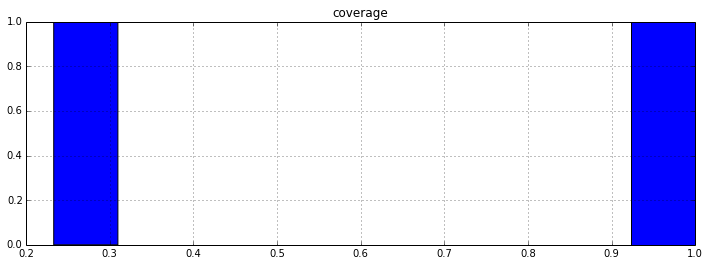

In [38]:
lf_stats = training_set.lf_stats()
lf_stats[:5]
lf_stats.hist("coverage")

In [56]:
from snorkel.snorkel import Learner
import snorkel.learning
from snorkel.learning import LogReg

learner = Learner(training_set, model=LogReg())

# Splitting into CV and test set
n_half = len(gold_candidates)/2
test_candidates = gold_candidates[:n_half]
test_labels     = gold_labels[:n_half]
cv_candidates   = gold_candidates[n_half:]
cv_labels       = gold_labels[n_half:]

from snorkel.learning_utils import GridSearch
gs       = GridSearch(learner, ['mu', 'lf_w0'], [[1e-5, 1e-7],[1.0,2.0]])
gs_stats = gs.fit(cv_candidates, cv_labels)

Testing mu = 1.00e-05, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.031467
	Learning epoch = 250	Gradient mag. = 0.085465
	Learning epoch = 500	Gradient mag. = 0.216229
	Learning epoch = 750	Gradient mag. = 0.280481
Final gradient magnitude for rate=0.01, mu=1e-05: 0.287
Applying LFs...
Featurizing...
Testing mu = 1.00e-05, lf_w0 = 2.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.062797
	Learning epoch = 250	Gradient mag. = 0.162584
	Learning epoch = 500	Gradient mag. = 0.283069
	Learning epoch = 750	Gradient mag. = 0.290400
Final gradient magnitude for rate=0.01, mu=1e-05: 0.301
Testing mu = 1.00e-07, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.031467
	Learning epoch = 250	Gradient mag. = 0.085637
	Learning epoch = 500	Gradient mag. = 0.216796
	Learning epoch = 750	Gradient mag. = 0.280510
Final gradient magnitude for rate=0.01, mu=1e-07: 0.287
Testin

In [57]:
gs_stats

,mu,lf_w0,Prec.,Rec.,F1
0,0.00001,1,1,1,1
1,0.00001,2,1,1,1
2,0.00000,1,1,1,1
3,0.00000,2,1,1,1


In [70]:
learner.test_wmv(test_candidates, test_labels)

Test set size:	14
----------------------------------------
Precision:	1.0
Recall:		1.0
F1 Score:	1.0
----------------------------------------
TP: 7 | FP: 0 | TN: 7 | FN: 0
Applying LFs...
Featurizing...


array([ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
       -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
        1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
       -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.])

In [75]:
preds = learner.predict_wmv(candidates)
resolved_acronyms = [spair2uid(c) for (c, p) in zip(candidates, preds) if p == 1]
print resolved_acronyms[:10]

Applying LFs...
Featurizing...
[('17903293', u'CD40 Ligand, serum & plasma', u'CD40L'), ('17903293', u'C-reactive protein', u'CRP'), ('17903293', u'Intercellular adhesion molecule-1', u'ICAM1'), ('17903293', u'Interleukin-6', u'IL6'), ('17903293', u'Urinary isoprostanes/creatinine', u'IsoCrUrine'), ('17903293', u'Monocyte chemoattractant protein-1', u'MCP1'), ('17903293', u'Myeloperoxidase', u'MPO'), ('17903293', u'Osteoprotegerin', u'OPG'), ('17903293', u'P-selectin', u'Pselectin'), ('17903293', u'Tumor necrosis factor alpha', u'TNFA')]


In [47]:
# mislabeled_cand = learner.mislabeled_test_candidates(test_candidates, test_labels)
# for (c,p,g) in mislabeled_cand[:10]:
#     print c.span0.context.document.name
#     print c.span0.context    
#     print c.span1.context
#     print

17903293
Phrase('17903293', 0, 10, 0, u'2')
Phrase('17903293', 0, 9, 0, u'CD40L')



### Classifying sentence acronyms

In [63]:
from snorkel.candidates import UnionExtractor

contexts = [corpus.get_sentences(), text_corpus.get_sentences()]
extractors = [txt_tab_extractor, txt_tab_extractor]
joint_extractor = UnionExtractor(extractor_list=extractors, context_list=contexts)
text_c = joint_extractor.union()
print len(text_c)

169


In [82]:
# helpers
def spairtxt2uid(span_pair):
    doc_id = span_pair.span0.context.document.name
    str1 = span_pair.span0.get_span()
    str2 = span_pair.span1.get_span()
    acro = str2[1:-1]
    phen = str1.split(' (')[0]
    return (doc_id, phen, acro)

We really trust the first stage, so if an acronym has been resolved there, remove it from this stage

In [84]:
new_text_c = list()
resolved = {(doc_id, acro) for doc_id, _, acro in resolved_acronyms}
for c in text_c:
    doc_id, phen, acro = spairtxt2uid(c)
    print doc_id, phen, acro
    if (doc_id, acro) not in resolved:
        new_text_c.append(c)

print len(new_text_c)

17684544 sub-entity of inflammatory bowel disease IBD
17684544 of inflammatory bowel disease IBD
17684544 inflammatory bowel disease IBD
17684544 bowel disease IBD
17684544 disease IBD
17903292 ) and urinary albumin excretion UAE
17903292 and urinary albumin excretion UAE
17903292 Glomerular filtration rate GFR
17903292 urinary albumin excretion UAE
17903292 filtration rate GFR
17903292 albumin excretion UAE
17903292 rate GFR
17903292 excretion UAE
17903292 Mapping 100K single nucleotide polymorphism SNP
17903292 100K single nucleotide polymorphism SNP
17903292 single nucleotide polymorphism SNP
17903292 nucleotide polymorphism SNP
17903292 polymorphism SNP
17903292 creatinine and cystatin-C cysC
17903292 and cystatin-C cysC
17903292 cystatin-C cysC
17903292 Thyroid stimulating hormone TSH
17903292 stimulating hormone TSH
17903292 hormone TSH
17903292 data using generalized estimating equations GEE
17903292 using generalized estimating equations GEE
17903292 generalized estimating equa

In [77]:
from snorkel.features import NgramPairFeaturizer

pkl_f = 'acro_text_feats.pkl'
try:
    with open(pkl_f, 'rb') as f:
        featurizer = cPickle.load(f)
except:
    featurizer = NgramPairFeaturizer()
    featurizer.fit_transform(text_c)

Building feature index...
Extracting features...
0/4741


In [86]:
# Split into train and test set
training_candidates = []
gold_candidates     = []
gold_labels         = []
n_half = len(text_c)/2
for c in text_c[:n_half]:
    uid = spair2uid(c)
    if uid in annotations:
        gold_candidates.append(c)
        gold_labels.append(annotations[uid])
    else:
        training_candidates.append(c)
training_candidates.extend(text_c[n_half:])
gold_labels = np.array(gold_labels)
print "Training set size: %s" % len(training_candidates)
print "Gold set size: %s" % len(gold_candidates)
print "Positive labels in training set: %s" % len([c for c in training_candidates if annotations.get(spair2uid(c),0)==1])
print "Negative labels in training set: %s" % len([c for c in training_candidates if annotations.get(spair2uid(c),0)==-1])
print "Positive labels in gold set: %s" % len([c for c in gold_candidates if annotations[spair2uid(c)]==1])
print "Negative labels in gold set: %s" % len([c for c in gold_candidates if annotations[spair2uid(c)]==-1])

Training set size: 85
Gold set size: 84
Positive labels in training set: 14
Negative labels in training set: 64
Positive labels in gold set: 16
Negative labels in gold set: 68


In [104]:
# positive LFs
def LF_acro_matches(m):
    _, phen, acro = spairtxt2uid(m)
    words = phen.strip().split()
    if len(acro) == len(words):
        w_acro = ''.join([w[0] for w in words])
        if w_acro.lower() == acro.lower():
            return +1
    return 0

def LF_acro_first_letter(m):
    _, phen, acro = spairtxt2uid(m)
    if not any(l.islower() for l in phen): return 0
    words = phen.strip().split()
    if len(acro) <= len(words):
        if words[0].lower() == acro[0].lower():
            return +1
    return 0

def LF_acro_second_letter(m):
    _, phen, acro = spairtxt2uid(m)
    if not any(l.islower() for l in phen): return 0
    if len(acro) < 4: return 0
    acro = acro[1:]
    words = phen.strip().split()
    if len(acro) <= len(words):
        if words[0].lower() == acro[0].lower():
            return +1
    return 0

def LF_acro_matches_last_letters(m):
    _, phen, acro = spairtxt2uid(m)
    if len(acro) < 4: return 0
    words = phen.strip().split()
    for r in (1,2):
        new_acro = acro[r:]
        if len(new_acro) == len(words):
            w_acro = ''.join([w[0] for w in words])
            if w_acro.lower() == new_acro.lower():
                return +1
    return 0

LF_txt_pos = [LF_acro_matches, LF_acro_first_letter, LF_acro_second_letter, LF_acro_matches_last_letters]

# negative LFs
def LF_no_pos(m):
    return -1 if not any(LF(m) for LF in LF_txt_pos) else 0

def LF_short(m):
    _, phen, acro = spairtxt2uid(m)
    return -1 if len(acro) == 1 else 0

def LF_lc(m):
    _, phen, acro = spairtxt2uid(m)
    return -1 if all(l.islower() for l in acro) else 0

def LF_uc(m):
    _, phen, acro = spairtxt2uid(m)
    return -1 if not any(l.islower() for l in phen) else 0

LF_txt_neg = [LF_no_pos, LF_short, LF_lc, LF_uc]

LF_txt = LF_txt_pos + LF_txt_neg

In [105]:
from snorkel.snorkel import TrainingSet
from snorkel.features import NgramFeaturizer

training_set = TrainingSet(training_candidates, LF_txt, featurizer=NgramPairFeaturizer())

Applying LFs...
Featurizing...
Building feature index...
Extracting features...
0/2639
LF Summary Statistics: 8 LFs applied to 85 candidates
------------------------------------------------------------
Coverage (candidates w/ > 0 labels):		100.00%
Overlap (candidates w/ > 1 labels):		0.00%
Conflict (candidates w/ conflicting labels):	0.00%


array([[<matplotlib.axes.AxesSubplot object at 0x122847890>]], dtype=object)

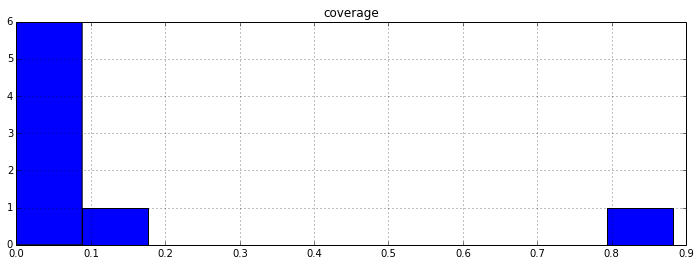

In [106]:
lf_stats = training_set.lf_stats()
lf_stats[:5]
lf_stats.hist("coverage")

In [107]:
from snorkel.snorkel import Learner
import snorkel.learning
from snorkel.learning import LogReg

learner = Learner(training_set, model=LogReg())

# Splitting into CV and test set
n_half = len(gold_candidates)/2
test_candidates = gold_candidates[:n_half]
test_labels     = gold_labels[:n_half]
cv_candidates   = gold_candidates[n_half:]
cv_labels       = gold_labels[n_half:]

from snorkel.learning_utils import GridSearch
gs       = GridSearch(learner, ['mu', 'lf_w0'], [[1e-5, 1e-7],[1.0,2.0]])
gs_stats = gs.fit(cv_candidates, cv_labels)

Testing mu = 1.00e-05, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.028264
	Learning epoch = 250	Gradient mag. = 0.037159
	Learning epoch = 500	Gradient mag. = 0.046830
	Learning epoch = 750	Gradient mag. = 0.059227
Final gradient magnitude for rate=0.01, mu=1e-05: 0.075
Applying LFs...
Featurizing...
Testing mu = 1.00e-05, lf_w0 = 2.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.052861
	Learning epoch = 250	Gradient mag. = 0.065779
	Learning epoch = 500	Gradient mag. = 0.077591
	Learning epoch = 750	Gradient mag. = 0.091226
Final gradient magnitude for rate=0.01, mu=1e-05: 0.107
Testing mu = 1.00e-07, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.028264
	Learning epoch = 250	Gradient mag. = 0.037191
	Learning epoch = 500	Gradient mag. = 0.046902
	Learning epoch = 750	Gradient mag. = 0.059349
Final gradient magnitude for rate=0.01, mu=1e-07: 0.075
Testin

In [108]:
gs_stats

,mu,lf_w0,Prec.,Rec.,F1
0,0.00001,1,0.833333,0.625,0.714286
1,0.00001,2,0.857143,0.750,0.800000
2,0.00000,1,0.833333,0.625,0.714286
3,0.00000,2,0.857143,0.750,0.800000


Applying LFs...
Featurizing...


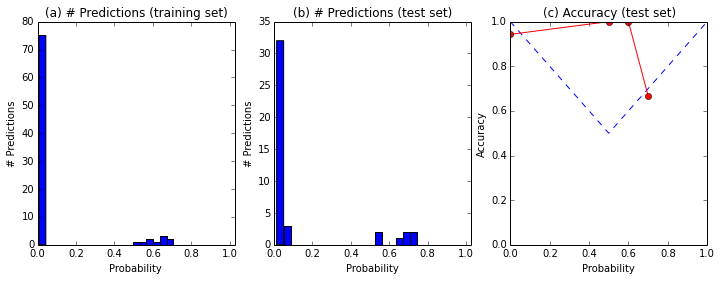

Test set size:	42
----------------------------------------
Precision:	0.857142857143
Recall:		0.75
F1 Score:	0.8
----------------------------------------
TP: 6 | FP: 1 | TN: 33 | FN: 2


In [109]:
learner.test(test_candidates, test_labels)

In [110]:
mislabeled_cand = learner.mislabeled_test_candidates(test_candidates, test_labels)
for (c,p,g) in mislabeled_cand[:10]:
    print c.span0.context.document.name, p, g
    print c.span0.context    
    print c.span0.get_span(), c.span1.get_span()
    print

17903292 1 -1
Sentence(Document('17903292', Corpus (GWAS Text Corpus)), 3, u'We tested for association between the Affymetrix GeneChip Human Mapping 100K single nucleotide polymorphism (SNP) set and measures of kidney function and endocrine traits.')
single nucleotide polymorphism (SNP) (SNP)

17903292 -1 1
Sentence(Document('17903292', Corpus (GWAS Text Corpus)), 5, u'Serum creatinine and cystatin-C (cysC; n = 981) were measured at the seventh examination cycle (1998\u20132001); GFR (n = 1010) was estimated via the Modification of Diet in Renal Disease (MDRD) equation; UAE was measured on spot urine samples during the sixth examination cycle (1995\u20131998) and was indexed to urinary creatinine (n = 822).')
cystatin-C (cysC; (cysC;

17903293 -1 1
Sentence(Document('17903293', Corpus (GWAS Text Corpus)), 8, u'With  GEE , 58 SNPs had p < 10 -6 : the top SNPs were rs2494250 (p = 1.00*10 -14 ) and rs4128725 (p = 3.68*10 -12 ) for monocyte chemoattractant protein-1 (MCP1), and rs2794520 (